In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

#Functions for reading and adding some extra data (rescaled variables)

In [3]:
def file_to_nparray(filepath, rows_to_skip):
  '''This function takes a string filepath which must have been generated according to program.cpp, i.e. it is going to craft and return an
  array out of the data in the file whose path is filepath but skipping the first eight lines of such file. The separator used is tabulator
  and takes no header, i.e. no initial row of column names'''

  myArray = pd.read_table(filepath, sep='\t', header=None, skiprows=rows_to_skip)
  return np.array(myArray, dtype=float)

In [4]:
def complete_array(array, Tc, L, beta, gamma, nu):
  '''This function takes a bidimensional array array which must have five columns for temperature, magnetization, magnetization typical deviation, 
  magnetic susceptibility and binder cumulant, respectively. It also takes a critical temperature Tc, the side length of an square bidimensional 
  ising grid and the value of the critical exponents beta, gamma and nu. It returns the same array but with three additional columns (the fifth, 
  the sixth and the seventh), which are (1-(T/Tc))*(L^(1/nu)), m*(L^(beta/nu)) and chi*(L^(-gamma/nu)), respectively.'''

  length = np.shape(array)[0]
  renormalized_T = np.empty((length,1),dtype=float)
  renormalized_m = np.empty((length,1),dtype=float)
  renormalized_chi = np.empty((length,1),dtype=float)

  aux_L = np.power(L, 1.0/nu)
  aux_L_2 = np.power(L, 1.0*beta/nu)
  aux_L_3 = np.power(L, -1.0*gamma/nu)

  for i in range(length):
    renormalized_T[i,0] = aux_L*(1-(array[i,0]/Tc))
    renormalized_m[i,0] = aux_L_2*array[i,1]
    renormalized_chi[i,0] = aux_L_3*array[i,3]

  return np.concatenate((array, renormalized_T, renormalized_m, renormalized_chi),axis=1)

In [5]:
def generate_array_of_arrays(filepaths_array, L_array, howManyLs, Tc, beta, gamma, nu, skipped_rows=8):
  '''This function takes two unidimensional arrays, filepaths_array and L_array. It also takes an integer howManyLs. Both arrays must have
  howManyLs elements. It also takes the value of the critical temperature, as well as the value for the ising critical exponents, beta, gamma
  and nu. This function uses the functions file_to_nparray() and complete_array() in order to craft a tridimensional numpy array mother_array,
  so that mother_array[i,:,:] is complete_array(file_to_nparray(filepaths_array[i]), Tc, L_array[i], beta, gamma, nu). The array in each
  filepath must have the same the same shape.'''
  if np.shape(filepaths_array)!=(howManyLs,) or np.shape(L_array)!=(howManyLs,):
    print('generate_array_of_arrays(), Err1')
    return -1
  basic_array_shape = np.shape(complete_array(file_to_nparray(filepaths_array[0], rows_to_skip=skipped_rows) ,Tc, L_array[0], beta, gamma, nu))
  mother_array = np.empty((howManyLs,basic_array_shape[0],basic_array_shape[1]))
  for i in range(howManyLs):
    mother_array[i,:,:] = complete_array(file_to_nparray(filepaths_array[i], rows_to_skip=skipped_rows), Tc, L_array[i], beta, gamma, nu)
  return mother_array

#Functions for plotting the raw results

In [6]:
def plot_and_save_m(mother_array, L_array, howManyLs, outpath, T_min=2.24, T_max=2.338, Tc=2/(np.log(1+np.sqrt(2)))):
  some_lower_Ts = np.linspace(start=T_min, stop=Tc, num=200)
  some_upper_Ts = np.linspace(start=Tc, stop=T_max, num=200) 

  plt.figure(figsize=(8,5.5))
  hlabel = r'$T$'
  vlabel = r'$m_0$'
  plt.xlabel(hlabel, fontsize=22)
  plt.ylabel(vlabel, fontsize=22)
  for k in range(howManyLs):
    plt.errorbar(mother_array[k,:,0], mother_array[k,:,1], yerr=mother_array[k,:,2], xerr=None, label='L='+str(L_array[k]))
    plt.plot(mother_array[k,:,0], mother_array[k,:,1])
  plt.plot(some_lower_Ts, np.power(1-np.power(np.sinh(2.0/some_lower_Ts),-4),1.0/8.0), color='k', label='A. S.')
  plt.plot(some_upper_Ts, np.zeros(np.shape(some_upper_Ts)), color='k')

  plt.grid()
  plt.legend(loc='lower left', frameon=True, fontsize=16)
  plt.savefig(outpath+'.png', format='png')
  plt.savefig(outpath+'.eps', format='eps')
  plt.show()
  return

In [7]:
def plot_and_save_chi(mother_array, L_array, howManyLs, outpath, Tc=2/(np.log(1+np.sqrt(2)))):
  plt.figure(figsize=(8,5.5))
  hlabel = r'$T$'
  vlabel = r'$\chi _T$'
  plt.xlabel(hlabel, fontsize=22)
  plt.ylabel(vlabel, fontsize=22)
  for k in range(howManyLs):
    plt.scatter(mother_array[k,:,0], mother_array[k,:,3], marker='1', label='L='+str(L_array[k]))
    plt.plot(mother_array[k,:,0], mother_array[k,:,3])
  plt.grid()
  plt.legend(loc='upper left', frameon=True, fontsize=16)
  plt.savefig(outpath+'.png', format='png')
  plt.savefig(outpath+'.eps', format='eps')
  plt.show()
  return

#Functions for fitting the critical exponents

In [8]:
def fit_beta(mother_array, L_array, outpath, Tc=2/(np.log(1+np.sqrt(2))), max_Tc = 2/(np.log(1+np.sqrt(2)))):
  '''This function fits the data in mother_array, as built according to generate_array_of_arrays() using np.polyfit() and the data for the 
  biggest system size, i.e. the biggest L. I will assume that the data matching the biggest system is allocated in the last slice of mother_array, 
  i.e. in mother_array[k,:,:] with the maximum k. It also receives the critical temperature, as well as the max_Tc, which is the maximum value of
  temperature above which the magnetization(T) datapoints are ignored. To start with, the beta fit is to be done using only T<Tc. According to
  this, we should use T=Tc so as to get the best possible beta fit. However, we find that the beta fit is better (i.e. it is closer to its
  tabulated value beta=1/8) if I ignore some of the datapoints which are the closest to the critical temperature. This may seem counter-productive
  as long as the critical behaviour emerges asymptotically close to the critical point. However, since the simulated system is finite, if we plot
  both the analytical solution and the computational solution for L=160, we see that one of the finite size effects is that the magnetization is
  not exactly zero when T->Tc^+, and such effect extends further below Tc (i.e. T->Tc^-), in the sense that it is necessary that T has grown
  bigger above Tc so that both the computational solution and the analytical solution converge.'''

  aux = np.shape(mother_array)
  aux = aux[0]
  #Indexing starts in 0, so we must correct aux<-aux-1 where the original aux holds the length of mother_array along the zero-th axis.
  aux = aux-1

  #Store the value of L for the data used for the fitting
  system_sidelength = L_array[aux]

  #Extract the useful data from mother_array
  temperatures = mother_array[aux,:,0]
  magnetization_data = mother_array[aux,:,1]

  aux = np.shape(temperatures)[0]
  cont = 0
  aux_cont = 0 

  for i in range(aux):
    if temperatures[i]<max_Tc:
      cont = cont+1
    if temperatures[i]<Tc:
      aux_cont = aux_cont +1

  T_to_fit = np.empty((cont,))
  m_to_fit = np.empty((cont,))
  T_without_cutoff = np.empty((aux_cont,))
  m_without_cutoff = np.empty((aux_cont,))

  cont = 0
  aux_cont = 0

  for i in range(aux):
    if temperatures[i]<max_Tc:
      T_to_fit[cont] = temperatures[i]
      m_to_fit[cont] = magnetization_data[i]
      cont = cont+1
    if temperatures[i]<Tc:
      T_without_cutoff[aux_cont] = temperatures[i]
      m_without_cutoff[aux_cont] = magnetization_data[i]
      aux_cont = aux_cont+1

  print('The temperatures used for the fitting are the following ones:')
  print(T_to_fit)
  print('These are the matching magnetizations:')
  print(m_to_fit)
  
  fit_parameters = np.polyfit(np.log(1-(T_to_fit/Tc)), np.log(m_to_fit), deg=1)
  print('The parameter fit values are:'+str(fit_parameters)+' for the fitting np.log(m_to_fit) vs. np.log(1-(T_to_fit/Tc))')
  print('The predicted value for beta is: '+str(fit_parameters[0]))

  #Plot the data and fit in logarithmic scale
  plt.figure(figsize=(8,5.5))
  hlabel = r'ln$(1-T/T_c)$'
  vlabel = r'ln$(m_0)$'
  plt.xlabel(hlabel, fontsize=22)
  plt.ylabel(vlabel, fontsize=22)

  plt.scatter(np.log(1-(T_without_cutoff/Tc)), np.log(m_without_cutoff), label=r'Results for $T<T_c$')
  plt.scatter(np.log(1-(T_to_fit/Tc)), np.log(m_to_fit), label='Fitted datapoints (L='+str(system_sidelength)+')')

  some_Ts = np.linspace(start=2.24, stop=Tc-0.001, num=200)
  plt.plot(np.log(1-(some_Ts/Tc)), (fit_parameters[0]*np.log(1-(some_Ts/Tc)))+fit_parameters[1], label='Data fit')

  plt.xlim((-8,-4))
  plt.ylim(-0.65,-0.3)
  plt.legend(loc='upper left', fontsize=18)
  plt.grid()
  plt.savefig(outpath+'_rescaledfit.png', format='png')
  plt.savefig(outpath+'_rescaledfit.eps', format='eps')
  plt.show()

  #Plot the raw data and analytical result
  some_lower_Ts = np.linspace(start=2.24, stop=Tc, num=200)
  some_upper_Ts = np.linspace(start=Tc, stop=2.338, num=200)
  plt.figure(figsize=(8,5.5))
  hlabel = r'$T$'
  vlabel = r'$m_0$'
  plt.xlabel(hlabel, fontsize=22)
  plt.ylabel(vlabel, fontsize=22)

  plt.plot(some_lower_Ts, np.power(1-np.power(np.sinh(2.0/some_lower_Ts),-4),1.0/8.0), color='k', label='Onsager solution')
  plt.plot(some_upper_Ts, np.zeros(np.shape(some_upper_Ts)), color='k')
  plt.scatter(temperatures, magnetization_data, label='Computational results')
  plt.scatter(T_to_fit, m_to_fit, label='Fitted datapoints (L='+str(system_sidelength)+')')
  
  plt.legend(loc='upper right', fontsize=16)
  plt.grid()
  plt.savefig(outpath+'_rawfit.png', format='png')
  plt.savefig(outpath+'_rawfit.eps', format='eps')
  plt.show()
  return

In [24]:
def fit_gamma(mother_array, L_array, outpath, Tc=2/(np.log(1+np.sqrt(2))), cutoff_Tc = Tc, use_lower_temperatures=True):
  '''This function fits the data in mother_array, as built according to generate_array_of_arrays() using np.polyfit() and the data for the 
  biggest system size, i.e. the biggest L. I will assume that the data matching the biggest system is allocated in the last slice of mother_array, 
  i.e. in mother_array[k,:,:] with the maximum k. It also receives the critical temperature, as well as an scalar cutoff_Tc. It also receives a
  boolean parameter which determines whether the datapoints used to do the fit are those with T<Tc or those with T>Tc. cutoff_Tc has here the
  same role as max_Tc in fit_beta(). Its function is to ignore some datapoints which are too close to the critical temperature, so that the
  finite size effects do not ruin the fit. In this case, the finite size effects have a disastrous impact on the fit. Remember that, in this case
  the main finite size effect keeps the magnetic susceptibility from actually diverging.'''

  if use_lower_temperatures==True and cutoff_Tc>Tc:
    print('fit_gamma(), Err1')
    return -1
  if use_lower_temperatures==False and cutoff_Tc<Tc:
    print('fit_gamma(), Err2')
    return -1

  aux = np.shape(mother_array)
  aux = aux[0]
  #Indexing starts in 0, so we must correct aux<-aux-1 where the original aux holds the length of mother_array along the zero-th axis.
  aux = aux-1

  #Store the value of L for the data used for the fitting
  system_sidelength = L_array[aux]

  #Extract the useful data from mother_array
  temperatures = mother_array[aux,:,0]
  susceptibility_data = mother_array[aux,:,3]

  aux = np.shape(temperatures)[0]
  cont = 0
  aux_cont = 0

  if use_lower_temperatures==True:
    for i in range(aux):
      if temperatures[i]<cutoff_Tc:
        cont = cont+1
      if temperatures[i]<Tc:
        aux_cont = aux_cont +1
      
  else:
      for i in range(aux):
        if temperatures[i]>cutoff_Tc:
          cont = cont+1
        if temperatures[i]>Tc:
          aux_cont = aux_cont +1

  T_to_fit = np.empty((cont,))
  chi_to_fit = np.empty((cont,))
  T_without_cutoff = np.empty((aux_cont,))
  chi_without_cutoff = np.empty((aux_cont,))

  cont = 0
  aux_cont = 0

  if use_lower_temperatures==True:
    for i in range(aux):
      if temperatures[i]<cutoff_Tc:
        T_to_fit[cont] = temperatures[i]
        chi_to_fit[cont] = susceptibility_data[i]
        cont = cont+1
      if temperatures[i]<Tc:
        T_without_cutoff[aux_cont] = temperatures[i]
        chi_without_cutoff[aux_cont] = susceptibility_data[i]
        aux_cont = aux_cont+1
  else:
    for i in range(aux):
      if temperatures[i]>cutoff_Tc:
        T_to_fit[cont] = temperatures[i]
        chi_to_fit[cont] = susceptibility_data[i]
        cont = cont+1
      if temperatures[i]>Tc:
        T_without_cutoff[aux_cont] = temperatures[i]
        chi_without_cutoff[aux_cont] = susceptibility_data[i]
        aux_cont = aux_cont+1

  print('The temperatures used for the fitting are the following ones:')
  print(T_to_fit)
  print('These are the matching susceptibilities:')
  print(chi_to_fit)
  
  fit_parameters = np.polyfit(np.log(np.abs(1-(T_to_fit/Tc))), np.log(chi_to_fit), deg=1)
  print('The parameter fit values are:'+str(fit_parameters)+' for the fitting np.log(chi_to_fit) vs. np.log(np.abs(1-((T_to_fit/Tc)))')
  print('The predicted value for -1.0*gamma is: '+str(fit_parameters[0]))

  plt.figure(figsize=(8,5.5))
  hlabel = r'ln$(|1-T/T_c|)$'
  vlabel = r'ln$(\chi_T)$'
  plt.xlabel(hlabel, fontsize=22)
  plt.ylabel(vlabel, fontsize=22)

  if use_lower_temperatures==True:
    plt.scatter(np.log(np.abs(1-(T_without_cutoff/Tc))), np.log(chi_without_cutoff), label=r'Results for $T<T_c$')
  else:
    plt.scatter(np.log(np.abs(1-(T_without_cutoff/Tc))), np.log(chi_without_cutoff), label=r'Results for $T>T_c$')

  plt.scatter(np.log(np.abs(1-(T_to_fit/Tc))), np.log(chi_to_fit), label='Fitted data points (L='+str(system_sidelength)+')')

  if use_lower_temperatures==True:
    some_Ts = np.linspace(start=2.24, stop=Tc, num=cont)
  else:
    some_Ts = np.linspace(start=Tc+0.001, stop=2.338, num=cont)

  plt.plot(np.log(np.abs(1-(some_Ts/Tc))), (fit_parameters[0]*np.log(np.abs(1-(some_Ts/Tc))))+fit_parameters[1], label='Data fit')

  plt.ylim((4,6.1))
  plt.legend(loc='lower left', fontsize=18)
  plt.grid()
  plt.savefig(outpath+'_rescaledfit.png', format='png')
  plt.savefig(outpath+'_rescaledfit.eps', format='eps')
  plt.show()

  plt.figure(figsize=(8,5.5))
  hlabel = r'$|1-T/T_c|$'
  vlabel = r'$\chi_T$'
  plt.xlabel(hlabel, fontsize=22)
  plt.ylabel(vlabel, fontsize=22)

  plt.scatter(np.abs(1-(temperatures/Tc)), susceptibility_data, label='Computational results')
  plt.scatter(np.abs(1-(T_to_fit/Tc)), chi_to_fit, label='Fitted data points (L='+str(system_sidelength)+')')

  if use_lower_temperatures==True:
    some_Ts = np.linspace(start=2.24, stop=Tc, num=200)
  else:
    some_Ts = np.linspace(start=Tc+0.001, stop=2.338, num=200)

  plt.plot(np.abs(1-(some_Ts/Tc)), np.exp(fit_parameters[1])*np.power(np.abs(1-(some_Ts/Tc)), fit_parameters[0]), label='Data fit')
  
  plt.ylim((0,400))
  plt.legend(loc='upper right', fontsize=14)
  plt.grid()
  plt.savefig(outpath+'_rawfit.png', format='png')
  plt.savefig(outpath+'_rawfit.eps', format='eps')
  plt.show()
  
  return

#Functions for plotting and saving the rescaled data

In [10]:
def plot_and_save_rescaled_m(mother_array, L_array, howManyLs, outpath):
  plt.figure(figsize=(8,5.5))
  hlabel = r'$(1-T/T_c)L^{1/\nu}$'
  vlabel = r'$m_0 L^{\beta/\nu}$'
  plt.xlabel(hlabel, fontsize=22)
  plt.ylabel(vlabel, fontsize=22)
  for i in range(howManyLs):
    plt.plot(mother_array[i,:,5], mother_array[i,:,6])
    plt.scatter(mother_array[i,:,5], mother_array[i,:,6], marker='1', label='L='+str(L_array[i]))
  plt.legend(loc='upper left', frameon=True, fontsize=17)
  plt.grid()
  plt.savefig(outpath+'.png', format='png')
  plt.savefig(outpath+'.eps', format='eps')
  plt.show()
  return

In [11]:
def plot_and_save_rescaled_chi(mother_array, L_array, howManyLs, outpath):
  plt.figure(figsize=(8,5.5))
  hlabel = r'$(1-T/T_c)L^{1/\nu}$'
  vlabel = r'$\chi _T L^{-\gamma/\nu}$'
  plt.xlabel(hlabel, fontsize=22)
  plt.ylabel(vlabel, fontsize=22)
  for i in range(howManyLs):
    plt.plot(mother_array[i,:,5], mother_array[i,:,7])
    plt.scatter(mother_array[i,:,5], mother_array[i,:,7], marker='1', label='L='+str(L_array[i]))
  plt.legend(loc='upper left', frameon=True, fontsize=17)
  plt.grid()
  plt.savefig(outpath+'.png', format='png')
  plt.savefig(outpath+'.eps', format='eps')
  plt.show()
  return

In [12]:
def plot_and_save_rescaled_binder(mother_array, L_array, howManyLs, outpath):
  plt.figure(figsize=(8,5.5))
  hlabel = r'$(1-T/T_c)L^{1/\nu}$'
  vlabel = r'$U_4$'
  plt.xlabel(hlabel, fontsize=22)
  plt.ylabel(vlabel, fontsize=22)
  for i in range(howManyLs):
    plt.plot(mother_array[i,:,5], mother_array[i,:,4])
    plt.scatter(mother_array[i,:,5], mother_array[i,:,4], marker='1', label='L='+str(L_array[i]))
  plt.legend(loc='upper left', frameon=True, fontsize=17)
  plt.grid()
  plt.savefig(outpath+'.png', format='png')
  plt.savefig(outpath+'.eps', format='eps')
  plt.show()
  return

#Functions for determining $T_c$ using the binder cumulant $U_4$

In [13]:
def plot_every_U4(mother_array, L_array, howManyLs, outpath, T_max):
  if np.shape(mother_array)[0]!=howManyLs or np.shape(L_array)!=(howManyLs,):
    print('plot_every_U4(), Err1')
    return -1
  howManyTs = np.shape(mother_array)[1]
  gathered_U4 = np.empty((howManyLs, howManyTs, 2))
  for k in range(howManyLs):
    gathered_U4[k,:,0] = mother_array[k,:,0]
    gathered_U4[k,:,1] = mother_array[k,:,4]

  plt.figure(figsize=(8,5.5))
  hlabel = r'$T$'
  vlabel = r'$U_4$'
  plt.xlabel(hlabel, fontsize=22)
  plt.ylabel(vlabel, fontsize=22)
  for k in range(howManyLs):
    plt.plot(gathered_U4[k,:,0], gathered_U4[k,:,1])
    plt.scatter(gathered_U4[k,:,0], gathered_U4[k,:,1], marker='1', label='L='+str(L_array[k]))
    plt.legend(loc='lower left', frameon=True, fontsize=17)
  #plt.xlim((2.24, T_max))
  #plt.ylim((0.5,0.7))
  plt.grid()
  plt.savefig(outpath+'.png', format='png')
  plt.savefig(outpath+'.eps', format='eps')
  plt.show()

  binder_mean = np.zeros((howManyTs,), dtype=float)
  binder_variance = np.zeros((howManyTs,), dtype=float)

  for k in range(howManyTs):
    for i in range(howManyLs):
      binder_mean[k] = binder_mean[k] + gathered_U4[i,k,1]
      binder_variance[k] = binder_variance[k] + np.power(gathered_U4[i,k,1], 2)
    binder_mean[k] = binder_mean[k]/howManyLs
    binder_variance[k] = binder_variance[k]/howManyLs
  
  for k in range(howManyTs):
    binder_variance[k] = binder_variance[k] - np.power(binder_mean[k], 2)
  
  plt.figure(figsize=(8,5.5))
  hlabel = r'$T$'
  vlabel = r'$\langle U_4 ^2\rangle -\langle U_4\rangle ^2$'
  plt.xlabel(hlabel, fontsize=22)
  plt.ylabel(vlabel, fontsize=22)
  plt.plot(gathered_U4[0,:,0], binder_variance)
  plt.scatter(gathered_U4[0,:,0], binder_variance)
  #plt.legend(loc='upper left', frameon=True, fontsize=17)
  plt.xlim((2.24, T_max))
  plt.ylim((0,0.0006))
  plt.grid()
  plt.savefig(outpath+'_variance.png', format='png')
  plt.savefig(outpath+'_variance.eps', format='eps')
  plt.show()

  

# Particularize the parameters for our case

In [14]:
Tc = 2/(np.log(1+np.sqrt(2)));
beta = 1.0/8.0
nu = 1
gamma = 7.0/4.0
L_array = np.array([40,80,120,160])

In [15]:
filepaths_array = []
filepaths_array.append('/content/drive/MyDrive/data_trial/L=40.dat')
filepaths_array.append('/content/drive/MyDrive/data_trial/L=80.dat')
filepaths_array.append('/content/drive/MyDrive/data_trial/L=120.dat')
filepaths_array.append('/content/drive/MyDrive/data_trial/L=160.dat')
filepaths_array = np.array(filepaths_array)

In [16]:
howManyLs=4

In [17]:
raw_m_outpath = '/content/drive/MyDrive/data_trial/raw_m'
raw_chi_outpath = '/content/drive/MyDrive/data_trial/raw_chi'
raw_binder_outpath = '/content/drive/MyDrive/data_trial/raw_binder'
collapse_outpath_m = '/content/drive/MyDrive/data_trial/m_rescaled'
collapse_outpath_chi = '/content/drive/MyDrive/data_trial/chi_rescaled'
collapse_outpath_binder = '/content/drive/MyDrive/data_trial/binder_rescaled'
fit_outpath_m = '/content/drive/MyDrive/data_trial/m_fit'
fit_outpath_chi = '/content/drive/MyDrive/data_trial/chi_fit'
fit_outpath_m_myTc = '/content/drive/MyDrive/data_trial/m_fit_myTc'
fit_outpath_chi_myTc = '/content/drive/MyDrive/data_trial/chi_fit_myTc'

# Generate the mother array

In [18]:
mother_array = generate_array_of_arrays(filepaths_array, L_array, howManyLs, Tc, beta, gamma, nu)

# Plot and save first results


##Plot raw results

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


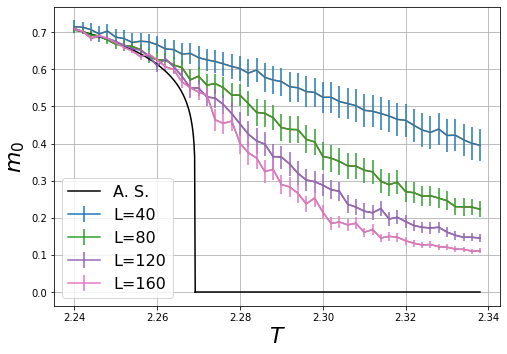

In [19]:
plot_and_save_m(mother_array, L_array, howManyLs, raw_m_outpath)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


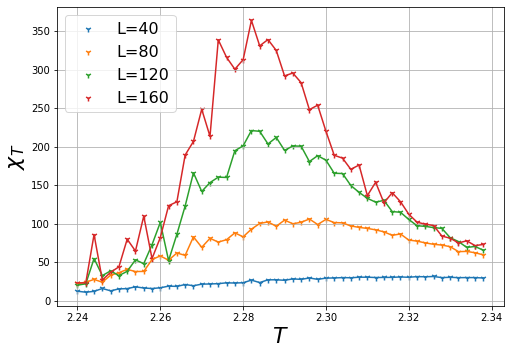

In [20]:
plot_and_save_chi(mother_array, L_array, howManyLs, raw_chi_outpath)

## Determine $T_c$

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


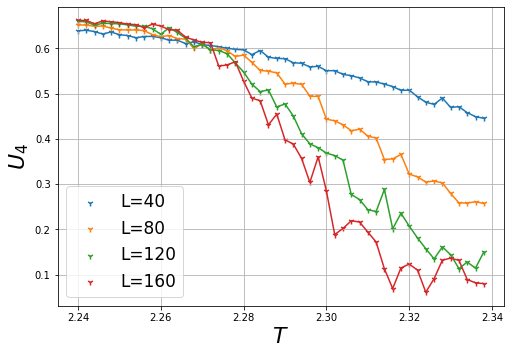

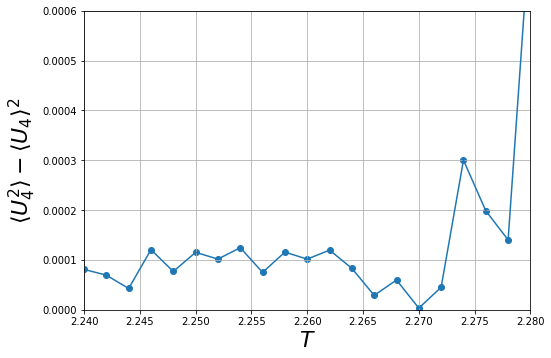

In [21]:
plot_every_U4(mother_array, L_array, howManyLs, raw_binder_outpath, 2.28)

Concluyo que:

>\begin{equation}
\boxed{T_c \simeq 2.270}
\end{equation}


## Determine critical exponents using $T_c=2/\text{ln}(1+\sqrt{2})$

The temperatures used for the fitting are the following ones:
[2.24  2.242 2.244 2.246 2.248 2.25  2.252 2.254 2.256 2.258 2.26  2.262]
These are the matching magnetizations:
[0.707375 0.70269  0.68462  0.690796 0.682862 0.671068 0.659146 0.649296
 0.633608 0.640915 0.62554  0.606996]
The parameter fit values are:[0.10708116 0.11361   ] for the fitting np.log(m_to_fit) vs. np.log(1-(T_to_fit/Tc))
The predicted value for beta is: 0.10708116045394739


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


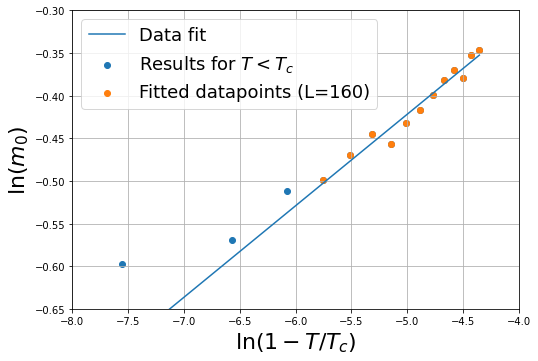

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


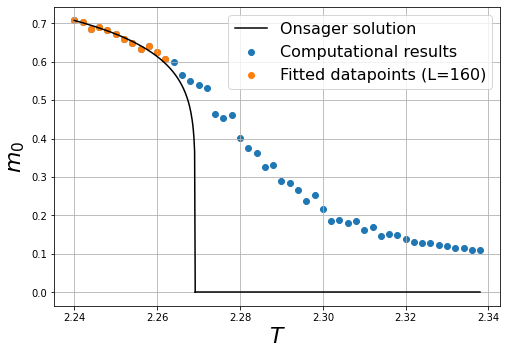

In [22]:
fit_beta(mother_array, L_array, fit_outpath_m, max_Tc = 2.264)

Concluyo que:

>\begin{equation}
\boxed{\beta \simeq 0.11}
\end{equation}

The temperatures used for the fitting are the following ones:
[2.308 2.31  2.312 2.314 2.316 2.318 2.32  2.322 2.324 2.326 2.328 2.33
 2.332 2.334 2.336 2.338]
These are the matching susceptibilities:
[175.991  136.338  153.629  126.927  140.027  128.402  112.15   101.758
  99.182   97.4834  83.7644  80.9954  74.9065  77.5766  71.3967  72.8843]
The parameter fit values are:[-1.56446348 -1.23180493] for the fitting np.log(chi_to_fit) vs. np.log(np.abs(1-((T_to_fit/Tc)))
The predicted value for -1.0*gamma is: -1.5644634751947533


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


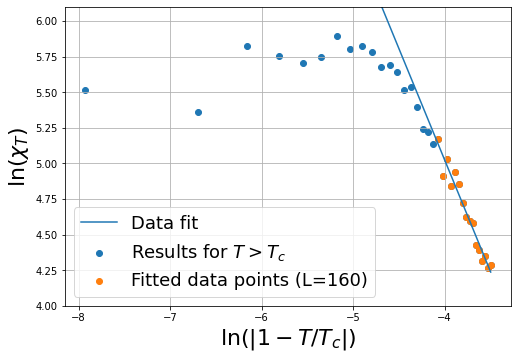

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


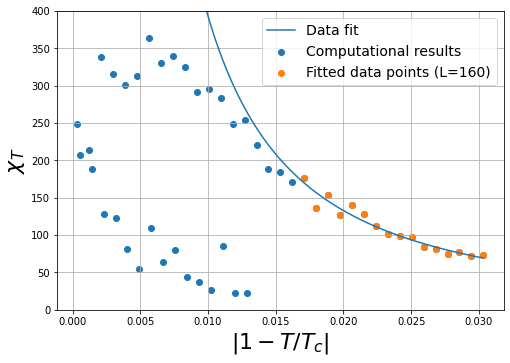

In [25]:
fit_gamma(mother_array, L_array, fit_outpath_chi, use_lower_temperatures=False, cutoff_Tc = 2.308)

Concluyo que:

>\begin{equation}
\boxed{\gamma \simeq 1.6}
\end{equation}

## Determine critical exponents using $T_c = 2.27$

In [28]:
mother_array_myTc = generate_array_of_arrays(filepaths_array, L_array, howManyLs, 2.27, beta, gamma, nu)

The temperatures used for the fitting are the following ones:
[2.24  2.242 2.244 2.246 2.248 2.25  2.252 2.254 2.256 2.258 2.26  2.262]
These are the matching magnetizations:
[0.707375 0.70269  0.68462  0.690796 0.682862 0.671068 0.659146 0.649296
 0.633608 0.640915 0.62554  0.606996]
The parameter fit values are:[0.11332627 0.138424  ] for the fitting np.log(m_to_fit) vs. np.log(1-(T_to_fit/Tc))
The predicted value for beta is: 0.11332626882782096


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


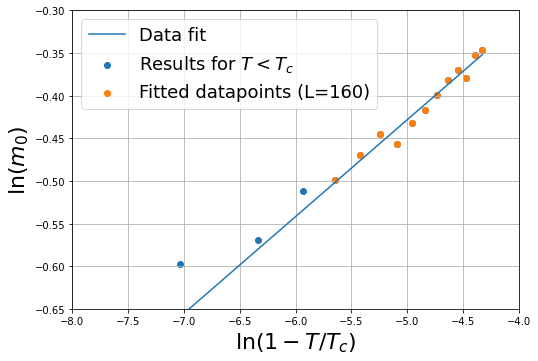

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in power
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


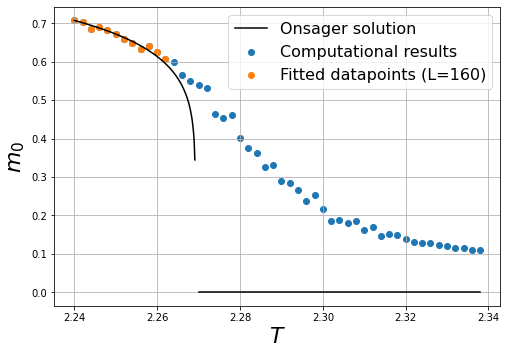

In [29]:
fit_beta(mother_array, L_array, fit_outpath_m_myTc, Tc = 2.27, max_Tc = 2.264)

The temperatures used for the fitting are the following ones:
[2.308 2.31  2.312 2.314 2.316 2.318 2.32  2.322 2.324 2.326 2.328 2.33
 2.332 2.334 2.336 2.338]
These are the matching susceptibilities:
[175.991  136.338  153.629  126.927  140.027  128.402  112.15   101.758
  99.182   97.4834  83.7644  80.9954  74.9065  77.5766  71.3967  72.8843]
The parameter fit values are:[-1.53969254 -1.16352755] for the fitting np.log(chi_to_fit) vs. np.log(np.abs(1-((T_to_fit/Tc)))
The predicted value for -1.0*gamma is: -1.5396925375227704


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


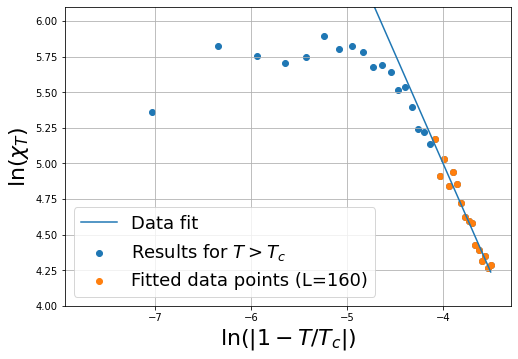

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


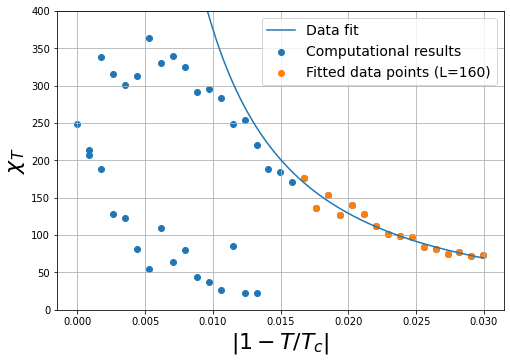

In [30]:
fit_gamma(mother_array, L_array, fit_outpath_chi_myTc, use_lower_temperatures=False, Tc = 2.27, cutoff_Tc = 2.308)

## Data collapse with tabulated data


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


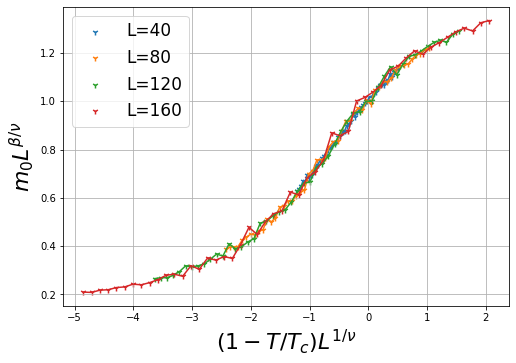

In [ ]:
plot_and_save_rescaled_m(mother_array, L_array, howManyLs, collapse_outpath_m)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


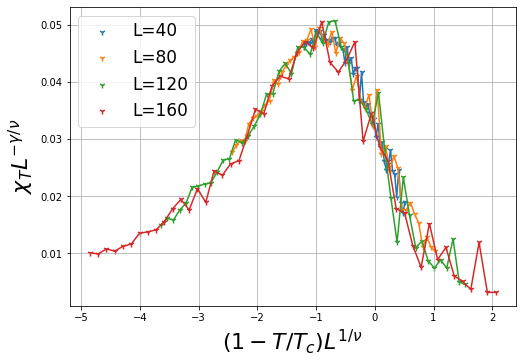

In [ ]:
plot_and_save_rescaled_chi(mother_array, L_array, howManyLs, collapse_outpath_chi)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


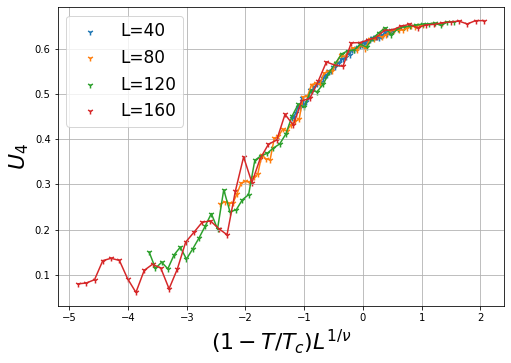

In [ ]:
plot_and_save_rescaled_binder(mother_array, L_array, howManyLs, collapse_outpath_binder)

##Data collapse with my data

In [ ]:
Tc = 2.27
beta = 0.10708116045394739
nu = 1
gamma = 1.5644634751947533
L_array = np.array([40,80,120,160])

In [ ]:
filepaths_array = []
filepaths_array.append('/content/drive/MyDrive/data_trial/L=40.dat')
filepaths_array.append('/content/drive/MyDrive/data_trial/L=80.dat')
filepaths_array.append('/content/drive/MyDrive/data_trial/L=120.dat')
filepaths_array.append('/content/drive/MyDrive/data_trial/L=160.dat')
filepaths_array = np.array(filepaths_array)

In [ ]:
howManyLs=4

In [ ]:
collapse_outpath_m = '/content/drive/MyDrive/data_trial/m_rescaled_mydata'
collapse_outpath_chi = '/content/drive/MyDrive/data_trial/chi_rescaled_mydata'
collapse_outpath_binder = '/content/drive/MyDrive/data_trial/binder_rescaled_mydata'

###Gotta generate the mother array according with my critical exponents and temperature

In [ ]:
mother_array = generate_array_of_arrays(filepaths_array, L_array, howManyLs, Tc, beta, gamma, nu)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


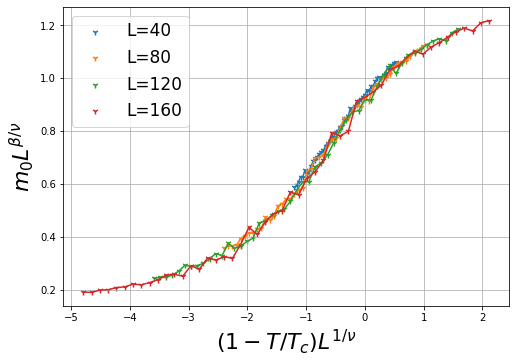

In [ ]:
plot_and_save_rescaled_m(mother_array, L_array, howManyLs, collapse_outpath_m)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


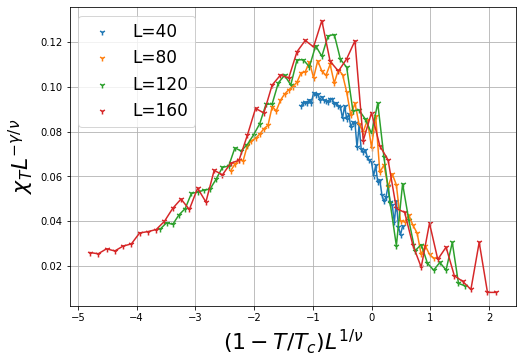

In [ ]:
plot_and_save_rescaled_chi(mother_array, L_array, howManyLs, collapse_outpath_chi)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


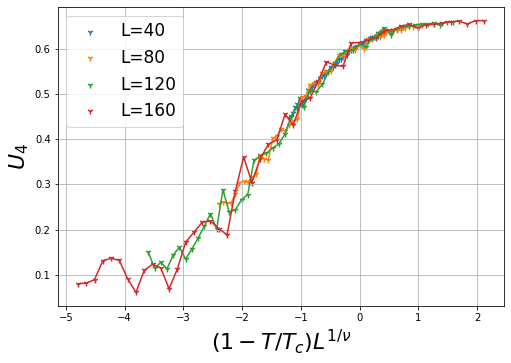

In [ ]:
plot_and_save_rescaled_binder(mother_array, L_array, howManyLs, collapse_outpath_binder)